## Clutch Hitting
Import the data and Define some functions

In [1]:
#Import libraries and s
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Column reference:
# https://baseballsavant.mlb.com/csv-docs

#Import Data
#Read in the Statcast Data - note this is around 4GB of data!
stat_15 = pd.read_csv('../data/external/statcast_15.zip', parse_dates=['game_date'])
stat_16 = pd.read_csv('../data/external/statcast_16.zip', parse_dates=['game_date'])
stat_17 = pd.read_csv('../data/external/statcast_17.zip', parse_dates=['game_date'])
stat_18 = pd.read_csv('../data/external/statcast_18.zip', parse_dates=['game_date'])
stat_19 = pd.read_csv('../data/external/statcast_19.zip', parse_dates=['game_date'])
stat_20 = pd.read_csv('../data/external/statcast_20.zip', parse_dates=['game_date'])

#Combine the data into a single dataframe
stat_years_combined_list = [
    stat_15, 
    stat_16, 
    stat_17, 
    stat_18, 
    stat_19,
    stat_20
]

stat_years_combined_df = pd.concat(
    stat_years_combined_list, 
    ignore_index=True
)

#Split out years
stat_years_combined_df['year'] = stat_years_combined_df[
    'game_date'
].apply(lambda x: x.strftime('%Y'))

#Subset for what I need
stat_comb = stat_years_combined_df[
    ['index', 
     'game_date',
     'year',
     'batter',
     'pitcher',
     'player_name',
     'events',
     'game_type',
     'home_team',
     'away_team',
     'home_score',
     'away_score',
     'bat_score',
     'fld_score',
     'on_1b',
     'on_2b',
     'on_3b',
     'post_home_score',
     'post_away_score',
     'inning',
     'hit_distance_sc',
     'launch_speed',
     'launch_angle',
     'launch_speed_angle',
     'effective_speed',
     'release_speed',
     'release_spin_rate',
     'estimated_ba_using_speedangle',
     'estimated_woba_using_speedangle',
     'pitch_name'
    ]
]

#add_player names
names = pd.read_csv('../data/external/name_master.csv', encoding = "utf-8")
#names.columns

print('Data imported successfully.\nFormatting and cleaning data...')

#Get we want regular season games:
stat_comb = stat_comb[stat_comb.game_type == 'R']

#Convert NaN to zero for the on-base colums=ns
values = {'on_1b':0,'on_2b':0,'on_3b':0}
stat_comb.fillna(value=values, inplace=True)

#Replace the playerID with an integer for the 1,2 and 3b colums:
stat_comb['on_1b'] = stat_comb['on_1b'].where(stat_comb['on_1b'] == 0, 1)
stat_comb['on_2b'] = stat_comb['on_2b'].where(stat_comb['on_2b'] == 0, 1)
stat_comb['on_3b'] = stat_comb['on_3b'].where(stat_comb['on_3b'] == 0, 1)

#stat_comb[['on_1b','on_2b','on_3b']].head(20)
print('Done!')

Data imported successfully.
Formatting and cleaning data...
Done!


Define workbook functions here

In [2]:
#Functions
from pybaseball import playerid_lookup

def is_clutch(df):
    '''A function which returns whether the event was in a clutch situation. 
    Takes a dataframe as input, returns boolean.
    Uses the statcasat dataset and requires the columns:
        'bat_score' -> int
        'fld_score' -> int
        'inning' -> int
        'on_1b' -> 1 or 0
        'on_2b' -> 1 or 0
        'on_3b' -> 1 or 0
    Note the is_clutch is defined as seen from the perspective of the batter. 
    '''
    if df['inning'] >= 7: #are we in the 7th inning or later, or 6th if we are in 2020?
        score_diff = df['bat_score'] - df['fld_score']
        if ((score_diff == 1) | (score_diff == 0)): #Are they tying, or leading by one point?
            return True
        elif score_diff < 0: #Are they trailing?
            #is the tying run 'on hand'?
            base_status = df['on_1b'] + df['on_2b'] + df['on_3b']#possible runs from bases. 
            if base_status + 2 + score_diff >= 0: 
                return True
            else:
                return False
        else:
            return False
    else:
        return False

## Analysis

Let's create two datasets, one during the clutch situations and one not during the clutch situations. 

In [3]:
#Write an extra column to determine whether the row event 
#was a clutch event
stat_comb['clutch'] = stat_comb.apply(is_clutch, axis=1)
stat_comb['clutch'].value_counts()

#Create the data frame with and without clutch events
clutch_df = stat_comb[stat_comb['clutch'] == True]
not_clutch_df = stat_comb[stat_comb['clutch'] == False]

#Sanity checks if required:
#clutch_df[['inning','year']].value_counts()
#clutch_df.columns

Launch Speed Angle

In [31]:
## Data Cleaning and Checks
#drop empty values:
clutch_df = clutch_df.dropna(how='any', subset=['launch_speed_angle'])
not_clutch_df = not_clutch_df.dropna(how='any', subset=['launch_speed_angle'])

#sanity_check:
#clutch_df.launch_speed_angle.agg(['unique','count'])
#not_clutch_df.launch_speed_angle.agg(['unique','count'])

#Group by batter
clutch_by_batter = clutch_df.groupby("batter")
nclutch_by_batter = not_clutch_df.groupby("batter")

In [32]:
#OK let's now see what percentage of batted events were Barrelled (6)

cb_batter = clutch_by_batter['launch_speed_angle'].agg([
    ('events','count'),
    ('clutch_bar%', lambda x: sum(x == 6)/x.count()*100)
]).sort_values(
    by = 'events',
    ascending = False
)

#Compare this to non-clutch situations
ncb_batter = nclutch_by_batter['launch_speed_angle'].agg([
    ('nc_events','count'),
    ('nclutch_bar%', lambda x: sum(x == 6)/x.count()*100)
]).sort_values(
    by = 'nc_events',
    ascending = False
)

In [33]:
#Let's filter only for players who have more faced a certain 
#amount of clutch and non-clutch situations:
min_events = 150
print("There are a total of {} players, we will filter to the experienced guys who have recorded clutch batting events at least {} times".format(len(cb_batter),min_events))

#Filter
cb_batter = cb_batter[cb_batter['events'] > min_events]
ncb_batter = ncb_batter[ncb_batter['nc_events'] > min_events]
print("Now we have {} players".format(len(cb_batter)))

#Join the dataframes on the player index
bar_comb = pd.merge(cb_batter,
                    ncb_batter, 
                    left_index = True, 
                    right_index = True, 
                    how = 'left'
                   )

#Let's create some new columns which is the differences:
bar_comb['bar%_delta'] = bar_comb['clutch_bar%'] - bar_comb['nclutch_bar%']

#add in names by joining with the name dataframe
bar_comb = bar_comb.reset_index()
bar_comb = pd.merge(bar_comb, names, left_on = 'batter', right_on = 'MLBCODE', how = 'left')
#bar_comb.head(20)

There are a total of 1260 players, we will filter to the experienced guys who have recorded clutch batting events at least 150 times
Now we have 254 players


In [30]:
#Run this if you want to save a df with a specific number of min_events, then go back and change the min events to not ruin the other calcs
barrel_df = bar_comb

In [34]:
#Some formatting
bar_comb = bar_comb[['bar%_delta','Name','batter']].sort_values(by = 'bar%_delta', ascending = False)

#Let's get some stats
bar_av = bar_comb['bar%_delta'].mean()
bar_med = bar_comb['bar%_delta'].median()
bar_std = bar_comb['bar%_delta'].std()


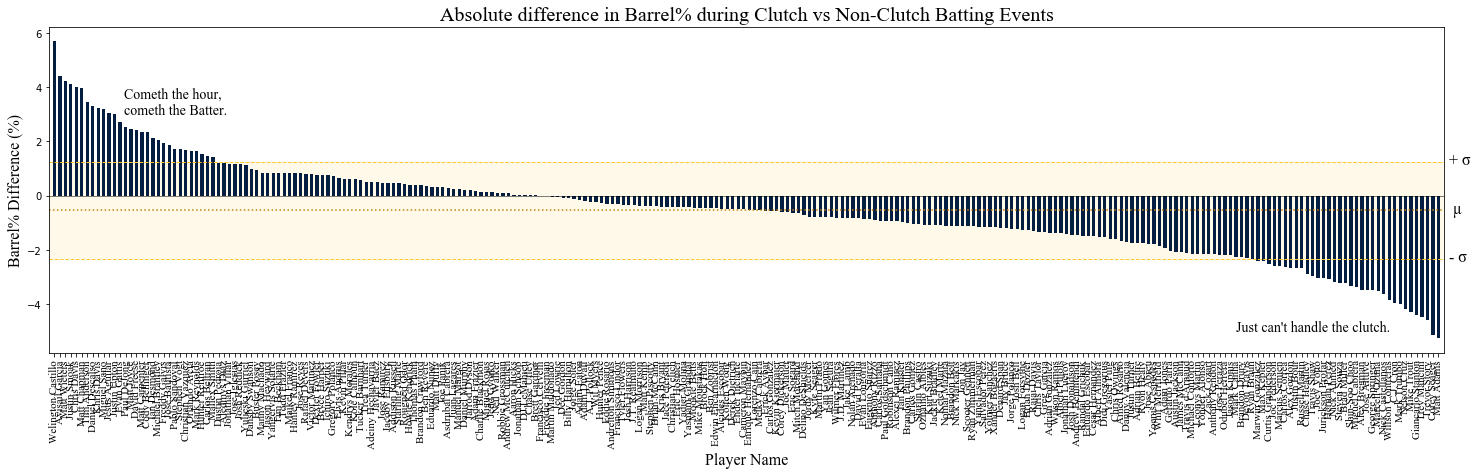

In [8]:
#Plot the data as a Barchart.
#Set ranges
y_up = bar_av + bar_std
y_low = bar_av - bar_std

fig, ax = plt.subplots(figsize = (25,6))
plt.xlim([-1,len(bar_comb)])

#Set up plot
ax.bar(x = bar_comb['Name'], height = bar_comb["bar%_delta"], width = 0.6, color = '#041E42')
ax.set_title("Absolute difference in Barrel% during Clutch vs Non-Clutch Batting Events",
            fontname = "Times New Roman",
             fontsize = 20)
ax.set_ylabel("Barrel% Difference (%)", fontname = "Times New Roman", fontsize = 16)
ax.set_xlabel("Player Name", fontname = "Times New Roman", fontsize = 16)
ax.set_xticklabels(bar_comb['Name'], rotation = 90, fontname = "Times New Roman", fontsize=11)
#ax.set_xticklabels([])

#Set the mean with stDev lines
ax.axhline(y=0, color='k', lw = 0.5)
ax.axhline(y_up, lw=1, color = '#FFC72C', linestyle = '--')
ax.axhline(bar_av, lw = 1.5, color = '#C4820F', linestyle = ':')
ax.axhline(y_low, lw=1, color = '#FFC72C', linestyle = '--')
ax.fill_between(range(-1,len(bar_comb)+1), y_low, y_up, facecolor='#FFC72C', alpha=0.1)

#Some labels
ax.text(len(bar_comb)/20,3,'Cometh the hour,\ncometh the Batter.', fontname = "Times New Roman", fontsize=14)
#ax.text(len(bar_comb)/3,0.45,'Within the plus side of 1 standard deviation.', fontname = "Times New Roman", fontsize=16)
#ax.text(len(bar_comb)/4,-1.5,'Within the minus side of 1 standard deviation.', fontname = "Times New Roman", fontsize=16)
ax.text(len(bar_comb)/20*17,-5,'Just can\'t handle the clutch.', fontname = "Times New Roman", fontsize=14)
ax.text(len(bar_comb)+1, y_up-0.1, '+ σ', fontname = "Times New Roman", fontsize=16)
ax.text(len(bar_comb)+1, bar_av-0.1, ' μ', fontname = "Times New Roman", fontsize=16)
ax.text(len(bar_comb)+1, y_low-0.1, '- σ', fontname = "Times New Roman", fontsize=16)

# Hide the right and top spines
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

plt.savefig('Barrelled.png', bbox_inches='tight')

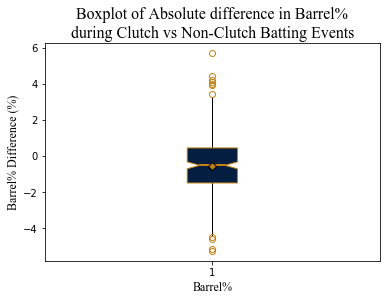

In [9]:
#Try Boxplot: 
fig, ax = plt.subplots()
ax.set_title("Boxplot of Absolute difference in Barrel%\nduring Clutch vs Non-Clutch Batting Events",
            fontname = "Times New Roman",
            fontsize = 16)
ax.set_ylabel("Barrel% Difference (%)", fontname = "Times New Roman", fontsize = 12)
ax.set_xlabel("Barrel%", fontname = "Times New Roman", fontsize = 12)
a1 = ax.boxplot(bar_comb["bar%_delta"], 
           notch=True,
           patch_artist=True,
           showcaps = False,
           showmeans = True,
           flierprops = dict(marker = 'o', markeredgecolor = '#C4820F'),
           meanprops = dict(markerfacecolor='#C4820F', marker='D', markeredgecolor ='k'),
           medianprops = dict(linewidth=2, color ='#C4820F'),
           boxprops = dict(color = '#C4820F', facecolor = '#041E42')
          )

plt.savefig('Barrelled_bp.png', bbox_inches='tight')

In [10]:
#Some stats:
#Percentage of players who don't improve in clutch events.
1- len(bar_comb[bar_comb['bar%_delta'] > 0]) / len(bar_comb) 
#The average:
bar_av
#The standard deviation
bar_std
#The median
bar_med

-0.5079252165593129

In [11]:
#Let's make a subset of the good and bad batters
new_comb = bar_comb[(bar_comb['bar%_delta'] > y_up) | (bar_comb['bar%_delta'] < y_low)]
#Let's import some batting statistics:
new_comb = new_comb.head(10).append(new_comb.tail(10), ignore_index=True)
new_df = new_comb[['Name','bar%_delta']]
new_df.columns = ['Batter','Barrel% Difference']

#Display formatting
#pd.options.display.float_format = '{:,.3}%'.format
#new_df.tail(10)
new_df.head(10)

,Batter,Barrel% Difference
0,Welington Castillo,5.692485
1,Avisail Garcia,4.430667
2,Matt Wieters,4.228821
3,Justin Smoak,4.106280
4,Chris Davis,4.005494
5,Matt Chapman,3.957672
6,Tim Anderson,3.452431
7,Daniel Descalso,3.294574
8,Khris Davis,3.242365
9,Miguel Sano,3.189418


# Let's do some hypothesis testing:

1. Are the two distributions normal?
2. Is the difference in mean statistically significant?

Let's look at the distributions and sample sizes and do a paired t-test.

In [35]:
barrel_df

,batter,events,clutch_bar%,nc_events,nclutch_bar%,bar%_delta,LASTNAME,FIRSTNAME,MLBCODE,Name
0,607680.0,406,4.433498,2121,3.818953,0.614544,Pillar,Kevin,607680.0,Kevin Pillar
1,605141.0,383,7.310705,2384,7.760067,-0.449362,Betts,Mookie,605141.0,Mookie Betts
2,592743.0,375,1.866667,1989,2.161890,-0.295224,Simmons,Andrelton,592743.0,Andrelton Simmons
3,520471.0,370,5.135135,1963,3.209373,1.925762,Galvis,Freddy,520471.0,Freddy Galvis
4,457763.0,369,6.233062,1703,5.284792,0.948271,Posey,Buster,457763.0,Buster Posey
...,...,...,...,...,...,...,...,...,...,...
834,670623.0,11,0.000000,64,0.000000,0.000000,Paredes,Isaac,670623.0,Isaac Paredes
835,460055.0,11,0.000000,65,3.076923,-3.076923,Mayberry,John,460055.0,John Mayberry
836,516472.0,11,9.090909,63,6.349206,2.741703,Arcia,Francisco,516472.0,Francisco Arcia
837,516811.0,11,0.000000,77,1.298701,-1.298701,Perez,Eury,516811.0,Eury Perez


In [36]:
def filter_bar_df(df, n):
    filtered_df = df[df['events'] > n]
    return filtered_df

filter and show descriptive statistics summary. 

In [37]:
barrel_df_150 = filter_bar_df(barrel_df, 150)
filtered_df = barrel_df_150[['batter','clutch_bar%', 'nclutch_bar%']]
filtered_df.describe()

,batter,clutch_bar%,nclutch_bar%
count,254.000000,254.000000,254.000000
mean,522995.578740,6.217810,6.754988
std,74798.397198,3.583165,3.409828
min,134181.000000,0.000000,0.219298
25%,458194.000000,3.377604,4.029605
50%,521081.500000,6.210994,6.687409
75%,592202.500000,8.165085,8.916650
max,657557.000000,20.129870,18.174342


So we can see that the barrel% in clutch situations is a little lower, is that significant? We ultimately want to do a pa-red t-test, but first let's look at some distributions to check for normality. 

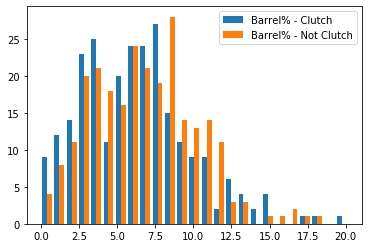

n_samples Clutch = 254
n_samples Not Clutch = 254


In [40]:
import matplotlib.pyplot as plt
from matplotlib import pyplot

bins = 25
clutch_pc = filtered_df['clutch_bar%']
non_clutch_pc = filtered_df['nclutch_bar%']

distributions = [clutch_pc, non_clutch_pc] 
plt.hist(distributions, bins, label=['Barrel% - Clutch', 'Barrel% - Not Clutch'])
plt.legend(loc='upper right')
plt.show()

print("n_samples Clutch = {}\nn_samples Not Clutch = {}".format(len(clutch_pc), len(non_clutch_pc)))

QQ plot for Clutch batting events


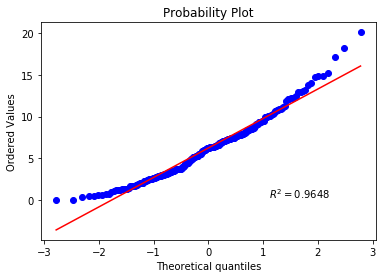

In [41]:
from scipy import stats
print('QQ plot for Clutch batting events')
res = stats.probplot(clutch_pc, plot=plt, rvalue=True)

QQ plot for Non-Clutch batting events


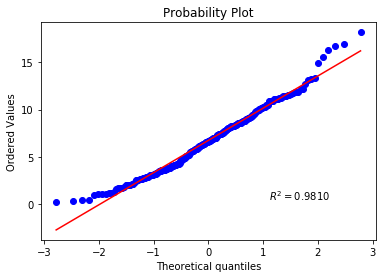

In [42]:
print('QQ plot for Non-Clutch batting events')
res = stats.probplot(non_clutch_pc, plot=plt, rvalue=True)

Comment: distributions are very similar, both show evidence of right skew, and light left tails? So we don't really have perfectly normal distributions, but we have 254 samples from over 150 batting events each, so we can probably invoke the CLT (central limit theorem) and continue. 

Paired T-test

use scipy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html

Assumptions:
* The dependent variable (DV) must be continuous which is measured on an interval or ratio scale - YES
* The observations are independent - big question mark
* The DV should be approximately normally distributed - porbably OK due to large n. 
        Apparently: The paired sample t-test is robust to this violation. If there is a violation of normality, as long as it’s not in a major violation the test results can be considered valid
* The DV should not contain any significant outliers - YES

AT conclusion: seems OK, but we need to check independence. The key thing here is, was it more related to a player being out of form - for instance. So then observations are not independent, but linked to the player form. 
    
ref: https://pythonfordatascienceorg.wordpress.com/paired-samples-t-test-python/

In [43]:
from scipy import stats

stats.ttest_rel(
    clutch_pc, 
    non_clutch_pc, 
    axis=0, 
    nan_policy='raise', 
    alternative='two-sided'
)

Ttest_relResult(statistic=-4.786078311945272, pvalue=2.8945523340043816e-06)

With a pvalue as per above (0.00000289) we reject the null hypothesis that the mean difference between the clutch and non-clutch barrel % is 0.

In [44]:
def run_ttest(data1, data2):
    return stats.ttest_rel(data1, data2, axis=0, nan_policy='omit', alternative='two-sided')[1]

In [96]:
#Define an array of minimum number of games:

def loop_calc(samples, df):
    
    results = pd.DataFrame({
    "N_events":[],
    "N_Players":[],
    "P-Value":[]
})

    for s in samples:
        df1 = filter_bar_df(df, s)
        ar1 = df1['clutch_bar%']
        ar2 = df1['nclutch_bar%']
        p = run_ttest(ar1,ar2)
        df2 = pd.DataFrame({"N_events":[s], "N_Players":[len(df1)],"P-Value":[p]})
        results = results.append(df2, ignore_index=True)
        
    return results

In [112]:
start = 10
stop = 350
step = 10
samples = np.arange(start,stop+step,step)

res_table = loop_calc(samples, barrel_df)

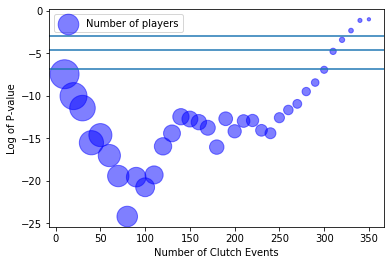

In [121]:
#Plot the results
x1 = res_table["N_events"]
size = res_table["N_Players"]
y = res_table["P-Value"]


plt.scatter(x1, np.log(y.values), s=size, c="blue", alpha=0.5)
plt.ylabel('Log of P-value')
plt.legend(['Number of players'])
plt.axhline(y=math.log(0.05))
plt.axhline(y=math.log(0.01))
plt.axhline(y=math.log(0.001))
plt.xlabel('Number of Clutch Events')
plt.show()